In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import scipy.special as special
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf 

from sklearn import preprocessing
from theano import shared

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [3]:
import sys, IPython, scipy, matplotlib, pandas, seaborn, patsy, platform, theano, sklearn, statsmodels
print("""This notebook was created using:
Python {}
IPython {}
PyMC3 {}
ArviZ {}
NumPy {}
SciPy {}
Pandas {}
Seaborn {}
Patsy {}
Matplotlib {}
Theano {}
Sklearn {}
Statsmodels {}\n""".format(sys.version[:5], 
                             IPython.__version__, 
                             pm.__version__, 
                             az.__version__, 
                             np.__version__, 
                             scipy.__version__, 
                             pandas.__version__, 
                             seaborn.__version__, 
                             patsy.__version__, 
                             matplotlib.__version__, 
                             theano.__version__, 
                             sklearn.__version__, 
                             statsmodels.api.__version__))

This notebook was created using:
Python 3.7.4
IPython 7.13.0
PyMC3 3.8
ArviZ 0.7.0
NumPy 1.18.2
SciPy 1.4.1
Pandas 1.0.3
Seaborn 0.10.0
Patsy 0.5.1
Matplotlib 3.2.1
Theano 1.0.4
Sklearn 0.22.2.post1
Statsmodels 0.11.1



# Chapter 8 Conditional Manatees

To model deeper conditionality—where the importance of one predictor depends upon another predictor --- we need interaction (also known as moderation).

### 8.1. Building an interaction

### 8.1.1. Making a rugged model. 

### Code 8.1

In [4]:
# load cars data
df = pd.read_csv("Data/rugged.csv", sep=";", header=0)

# make log version of outcome
df['log_gdp'] = np.log(df['rgdppc_2000'])

# extract countries with GDP data
d2f = df.dropna(axis=0, subset=['rgdppc_2000']).copy()

# rescale variables
d2f['log_gdp_std'] = d2f['log_gdp']/d2f['log_gdp'].mean()
d2f['rugged_std'] = d2f['rugged']/d2f['rugged'].max()

d2f.head()

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent,log_gdp,log_gdp_std,rugged_std
2,AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670.0,-12.299,...,3610000.0,5.669,6.981,4.926,3.872,1223208.0,2.000,7.492609,0.879712,0.138342
4,ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,...,0.0,NaN,NaN,NaN,NaN,200000.0,100.000,8.216929,0.964755,0.552564
7,ARE,784,United Arab Emirates,0.769,0.316,2.112,0.191,6.142,8360.0,23.913,...,0.0,NaN,NaN,NaN,NaN,19200.0,0.000,9.933263,1.166270,0.123992
8,ARG,32,Argentina,0.775,0.220,2.268,0.226,9.407,273669.0,-35.396,...,0.0,NaN,NaN,NaN,NaN,276632.0,89.889,9.407032,1.104485,0.124960
9,ARM,51,Armenia,2.688,0.934,8.178,0.799,50.556,2820.0,40.294,...,0.0,NaN,NaN,NaN,NaN,105743.0,0.500,7.792343,0.914904,0.433409


### Code 8.2

In [5]:
shared_R = shared(d2f['rugged_std'].values)
mean_rugged_std = d2f['rugged_std'].mean()
# define model: log_GDP ~ rugged
with pm.Model() as m8_1:
    a = pm.Normal('a', mu=1, sd=1)
    b = pm.Normal('b', mu=0, sd=1)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a+b*(shared_R-mean_rugged_std))
    log_gdp_std = pm.Normal('log_gdp_std', mu=mu, sd=sigma, observed=d2f['log_gdp_std'])
    m8_1_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3890.72draws/s]


In [6]:
# show model summary
varnames = ['~mu']
az.summary(m8_1_trace, varnames, kind="stats",  round_to=2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
a,1.00,0.01,0.98,1.02
b,0.00,0.06,-0.09,0.09
sigma,0.14,0.01,0.13,0.15


### Code 8.3

In [7]:
# draw priors
xseq = [0, 1]
shared_R.set_value(np.array(xseq))
with m8_1:
    m8_1_prior_predictive = pm.sample_prior_predictive() 

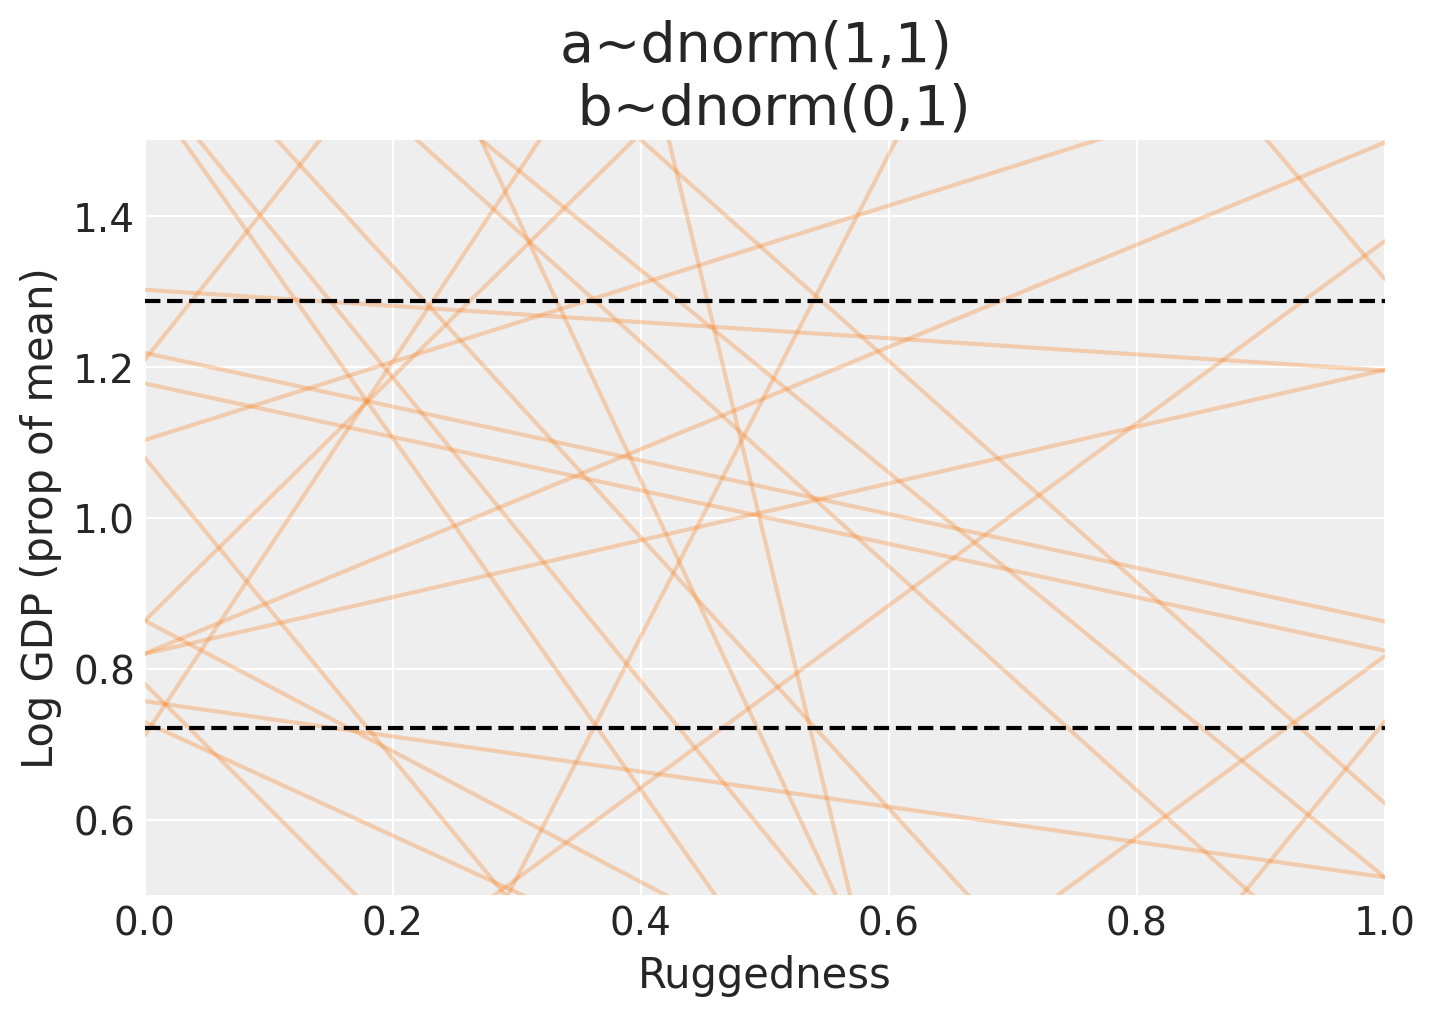

In [8]:
# plot results
fig = plt.figure(figsize=(8, 5))
for i in range(50):
    plt.plot(xseq, m8_1_prior_predictive['log_gdp_std'][i], c='C1', alpha=0.3)
plt.axhline(d2f['log_gdp_std'].min(), c="k", ls="--")
plt.axhline(d2f['log_gdp_std'].max(), c="k", ls="--")
plt.ylabel('Log GDP (prop of mean)', fontsize=15)
plt.xlabel('Ruggedness', fontsize=15)
plt.title('a~dnorm(1,1) \n b~dnorm(0,1)', fontsize=20)
plt.xlim(xseq)
plt.ylim([0.5, 1.5])
plt.show()

### Code 8.4

In [9]:
sum(abs(m8_1_prior_predictive['b'])>0.6) / len(m8_1_prior_predictive['b'])

0.514

### Code 8.5 and Code 8.6

In [10]:
mean_rugged_std = d2f['rugged_std'].mean()
# define model: log_GDP ~ rugged
with pm.Model() as m8_1:
    a = pm.Normal('a', mu=1, sd=0.1)
    b = pm.Normal('b', mu=0, sd=0.3)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a+b*(d2f['rugged_std']-mean_rugged_std))
    log_gdp_std = pm.Normal('log_gdp_std', mu=mu, sd=sigma, observed=d2f['log_gdp_std'])
    m8_1_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4051.44draws/s]


In [11]:
# show model summary
varnames = ['~mu']
az.summary(m8_1_trace, varnames, kind="stats",  round_to=2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
a,1.00,0.01,0.98,1.02
b,0.00,0.06,-0.09,0.09
sigma,0.14,0.01,0.13,0.15


### 8.1.2. Adding an indicator variable isn’t enough

### Code 8.7 - Code 8.10

In [12]:
# set index variable
d2f['africa_id'] = pd.Categorical(d2f['cont_africa']).codes

In [13]:
shared_R = shared(d2f['rugged_std'].values)
mean_rugged_std = d2f['rugged_std'].mean()
# define model: log_GDP ~ rugged
with pm.Model() as m8_2:
    a = pm.Normal('a', mu=1, sd=0.1, shape=d2f['africa_id'].max()+1)
    b = pm.Normal('b', mu=0, sd=0.3)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a[d2f['africa_id'].values]+b*(shared_R-mean_rugged_std))
    log_gdp_std = pm.Normal('log_gdp_std', mu=mu, sd=sigma, observed=d2f['log_gdp_std'])
    m8_2_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3485.85draws/s]


In [14]:
# show model summary
varnames = ['~mu']
az.summary(m8_2_trace, varnames, kind="stats",  round_to=2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
a[0],1.05,0.01,1.03,1.07
a[1],0.88,0.02,0.85,0.90
b,-0.05,0.05,-0.13,0.03
sigma,0.11,0.01,0.10,0.12


In [15]:
# model compare
pm.compare({'m8_1': m8_1_trace,
            'm8_2': m8_2_trace}, ic='WAIC', scale='deviance')

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/arviz/stats/stats.py:1210: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m8_2,0,-252.075,4.25597,0,0.999992,13.1836,0,True,deviance
m8_1,1,-188.848,2.58097,63.2267,8.26077e-06,14.7921,14.6878,False,deviance


### Code 8.11

In [16]:
diff_a1_a2 = m8_2_trace['a'][:,1] - m8_2_trace['a'][:,0]

In [17]:
az.summary(diff_a1_a2, kind="stats",  round_to=2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
x,-0.17,0.02,-0.2,-0.14


### Code 8.12

In [18]:
rugged_seq = np.linspace(-0.1, 1.1, 30)

In [19]:
# init saving space
mu_pred_NoAfrica = np.zeros((len(rugged_seq), len(m8_2_trace) * m8_2_trace.nchains))
# calculate posterior for each mu
for n, r in enumerate(rugged_seq):
    mu_pred_NoAfrica[n] = m8_2_trace['a'][:, 0] + m8_2_trace['b']*(r-mean_rugged_std)

In [20]:
# init saving space
mu_pred_Africa = np.zeros((len(rugged_seq), len(m8_2_trace) * m8_2_trace.nchains))
# calculate posterior for each mu
for n, r in enumerate(rugged_seq):
    mu_pred_Africa[n] = m8_2_trace['a'][:, 1] + m8_2_trace['b']*(r-mean_rugged_std)

In [21]:
# Function to map the colors as a list from the input list of x variables
def pltcolor(lst):
    cols=[]
    for l in lst:
        if l==0:
            cols.append('C0')
        else:
            cols.append('C1')
    return cols
# Create the colors list using the function above
cols = pltcolor(d2f['cont_africa'].values)

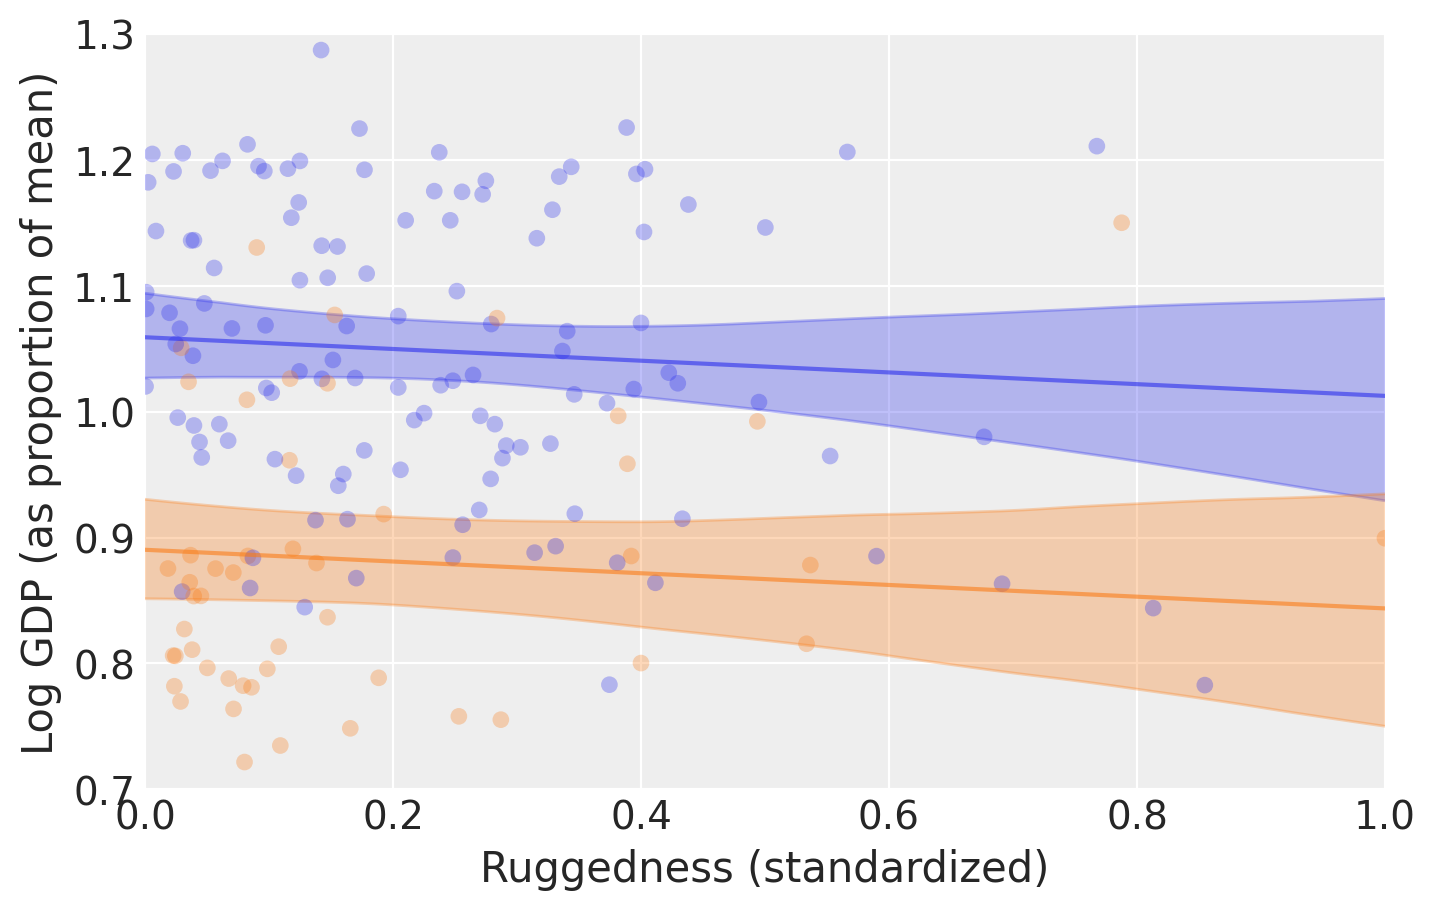

In [22]:
# plot results
fig = plt.figure(figsize=(8, 5))
# NoAfrica mean
plt.plot(rugged_seq, mu_pred_NoAfrica.mean(1), color='C0', alpha=0.6)
# NoAfrica CI for mean
az.plot_hpd(rugged_seq, mu_pred_NoAfrica.T, color='C0', 
            fill_kwargs={'alpha': 0.3}, credible_interval=0.97)
# Africa mean
plt.plot(rugged_seq, mu_pred_Africa.mean(1), color='C1', alpha=0.6)
# Africa CI for mean
az.plot_hpd(rugged_seq, mu_pred_Africa.T, color='C1', 
            fill_kwargs={'alpha': 0.3}, credible_interval=0.97)
plt.ylabel('Log GDP (as proportion of mean)', fontsize=15)
plt.xlabel('Ruggedness (standardized)', fontsize=15)
plt.xlim([0, 1])
plt.ylim([0.7, 1.3])
plt.scatter(d2f['rugged_std'], d2f['log_gdp_std'], c=cols,
               alpha=0.3, edgecolors='none')
plt.show()

### 8.1.3. Adding an interaction does work

### Code 8.13 and Code 8.14

In [23]:
# define model: log_GDP ~ rugged (slope condition)
with pm.Model() as m8_3:
    a = pm.Normal('a', mu=1, sd=0.1, shape=d2f['africa_id'].max()+1)
    b = pm.Normal('b', mu=0, sd=0.3, shape=d2f['africa_id'].max()+1)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a[d2f['africa_id'].values]+b[d2f['africa_id'].values]*(d2f['rugged_std']-mean_rugged_std))
    log_gdp_std = pm.Normal('log_gdp_std', mu=mu, sd=sigma, observed=d2f['log_gdp_std'])
    m8_3_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3491.78draws/s]


In [24]:
# show model summary
varnames = ['~mu']
az.summary(m8_3_trace, varnames, kind="stats",  round_to=2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
a[0],1.05,0.01,1.03,1.07
a[1],0.89,0.02,0.86,0.91
b[0],-0.14,0.06,-0.24,-0.06
b[1],0.13,0.07,0.01,0.24
sigma,0.11,0.01,0.10,0.12


### Code 8.15

In [25]:
# model compare
pm.compare({'m8_1': m8_1_trace,
            'm8_2': m8_2_trace,
            'm8_3': m8_3_trace}, ic='LOO', scale='deviance')

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m8_3,0,-259.36,4.90339,0,0.850247,12.7645,0,False,deviance
m8_2,1,-252.025,4.28087,7.33446,0.149753,14.4407,6.56937,False,deviance
m8_1,2,-188.841,2.58437,70.5181,3.49906e-09,14.4676,14.9153,False,deviance


### Code 8.16

In [26]:
m8_3_loo = pm.stats.loo(m8_3_trace, pointwise=True, reff=None, scale='deviance')
m8_3_loo['loo_i'].values

array([-2.52701297, -2.3956818 , -1.67017989, -2.39862044, -1.63185859,
       -2.52750126, -1.47015672,  1.07640042, -1.35183602, -0.87887185,
       -1.19960949, -2.26861265, -2.29480551,  1.47859417, -2.48611146,
       -2.23094794, -2.19147156, -2.49907222, -1.97926689, -2.34728806,
       -0.75518399, -2.45325609, -2.11172748,  0.49187363, -2.41817593,
       -1.01900411,  2.63266525, -2.35680712, -2.18272396, -2.51898856,
       -2.50194164, -1.63486453, -2.26472782, -2.44208486, -2.24798707,
       -1.86265619, -2.45719093, -0.76823048, -2.1247691 , -1.27456638,
       -2.45961134, -2.22345618, -1.16039938, -2.52459722, -0.87612801,
       -1.7613514 , -1.88525284, -1.4748735 , -1.14876864, -2.52969351,
       -1.04877492, -1.38325782, -2.33707334, -1.01682291, -0.33816806,
       -1.20772352, -1.45091061, -2.47432241, -2.5023319 , -2.51364609,
       -1.91040786,  3.21138499, -0.97040065, -2.51951543, -2.1804927 ,
       -1.7312848 , -0.17470347, -1.49745029, -2.49375485, -0.76

### 8.1.4. Plotting the interaction

### Code 8.17

In [27]:
#  Africa 
df_Africa = d2f[d2f['africa_id']==1]

In [28]:
rugged_seq = np.linspace(-0.1, 1.1, 30)
# init saving space
mu_pred_Africa = np.zeros((len(rugged_seq), len(m8_3_trace) * m8_3_trace.nchains))
# calculate posterior for each mu
for n, r in enumerate(rugged_seq):
    mu_pred_Africa[n] = m8_3_trace['a'][:, 1] + m8_3_trace['b'][:, 1]*(r-mean_rugged_std)

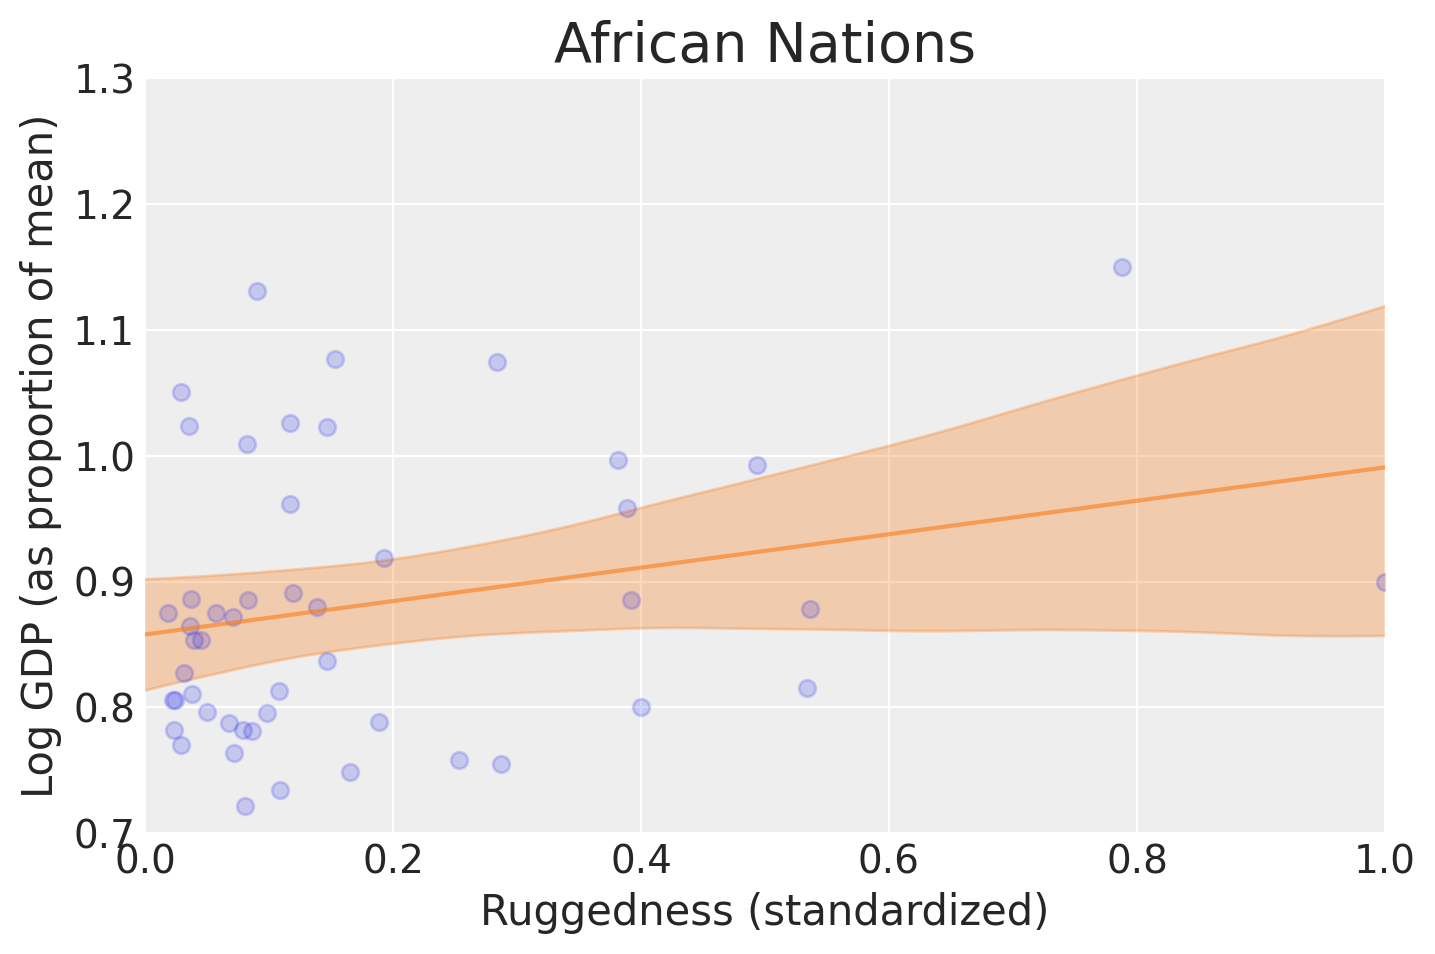

In [29]:
# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(df_Africa['rugged_std'], df_Africa['log_gdp_std'], 'o', alpha=0.2)
# Africa mean
plt.plot(rugged_seq, mu_pred_Africa.mean(1), color='C1', alpha=0.6)
# Africa CI for mean
az.plot_hpd(rugged_seq, mu_pred_Africa.T, color='C1', 
            fill_kwargs={'alpha': 0.3}, credible_interval=0.97)
plt.ylabel('Log GDP (as proportion of mean)', fontsize=15)
plt.xlabel('Ruggedness (standardized)', fontsize=15)
plt.title('African Nations', fontsize=20)
plt.xlim([0, 1])
plt.ylim([0.7, 1.3])
plt.show()

In [30]:
#  non-Africa 
df_NoAfrica = d2f[d2f['africa_id']==0]

In [31]:
# init saving space
mu_pred_NoAfrica = np.zeros((len(rugged_seq), len(m8_3_trace) * m8_3_trace.nchains))
# calculate posterior for each mu
for n, r in enumerate(rugged_seq):
    mu_pred_NoAfrica[n] = m8_3_trace['a'][:, 0] + m8_3_trace['b'][:, 0]*(r-mean_rugged_std)

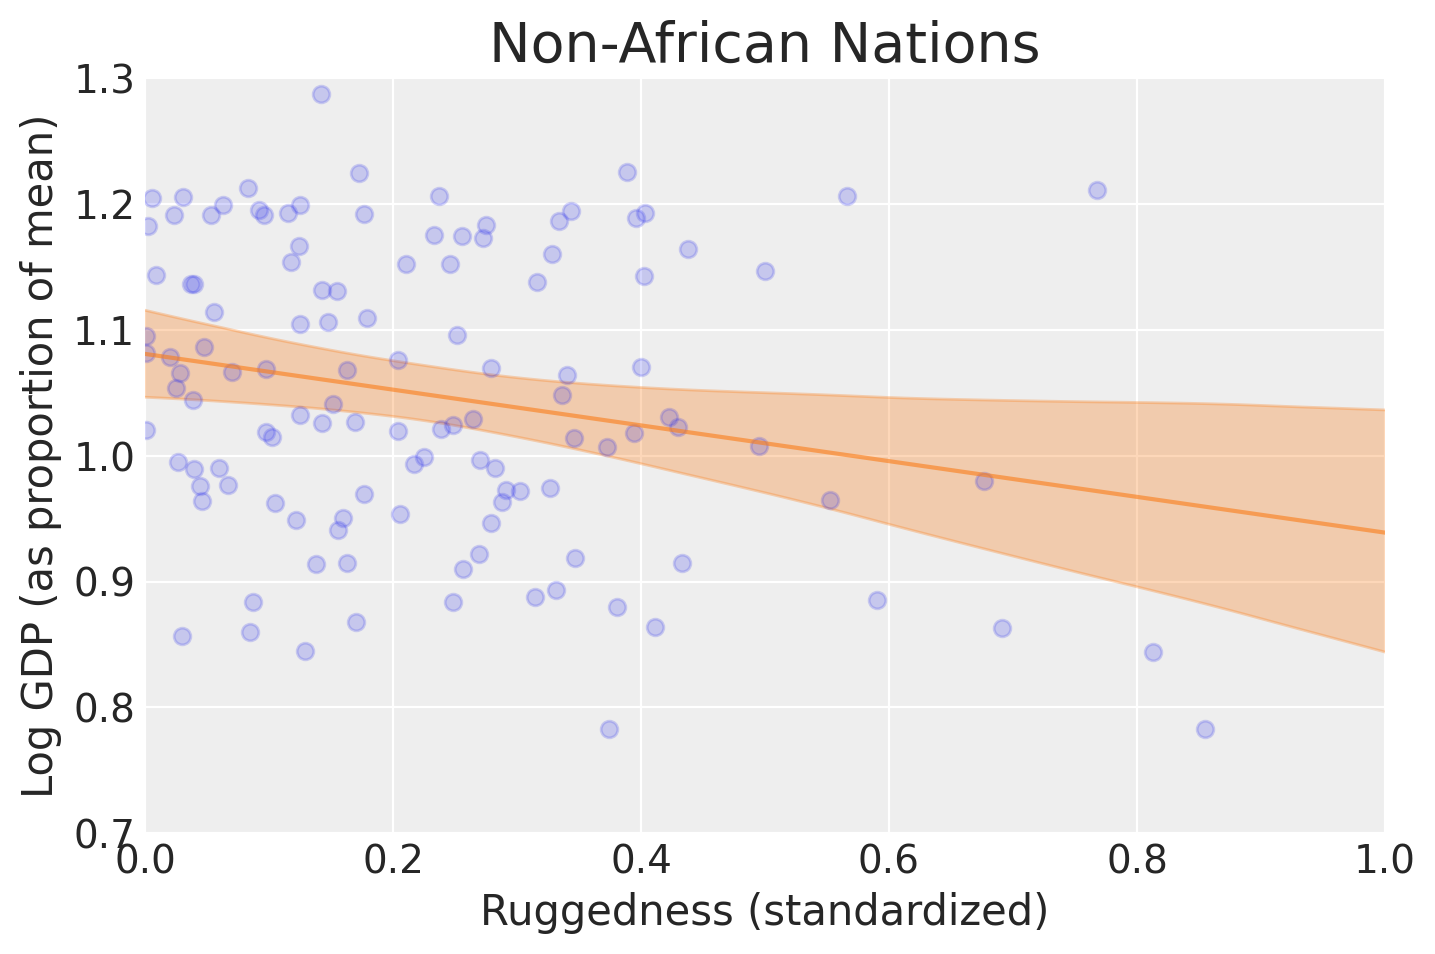

In [32]:
# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(df_NoAfrica['rugged_std'], df_NoAfrica['log_gdp_std'], 'o', alpha=0.2)
# NoAfrica mean
plt.plot(rugged_seq, mu_pred_NoAfrica.mean(1), color='C1', alpha=0.6)
# NoAfrica CI for mean
az.plot_hpd(rugged_seq, mu_pred_NoAfrica.T, color='C1', 
            fill_kwargs={'alpha': 0.3}, credible_interval=0.97)
plt.ylabel('Log GDP (as proportion of mean)', fontsize=15)
plt.xlabel('Ruggedness (standardized)', fontsize=15)
plt.title('Non-African Nations', fontsize=20)
plt.xlim([0, 1])
plt.ylim([0.7, 1.3])
plt.show()

## 8.2. Symmetry of interactions

### Code 8.18

In [33]:
rugged_seq = np.linspace(-0.2, 1.2, 30)

In [34]:
# init saving space
mu_pred_Africa = np.zeros((len(rugged_seq), len(m8_3_trace) * m8_3_trace.nchains))
mu_pred_NoAfrica = np.zeros((len(rugged_seq), len(m8_3_trace) * m8_3_trace.nchains))
# calculate posterior for each mu
for n, r in enumerate(rugged_seq):
    mu_pred_Africa[n] = m8_3_trace['a'][:, 1] + m8_3_trace['b'][:, 1]*(r-mean_rugged_std)
    mu_pred_NoAfrica[n] = m8_3_trace['a'][:, 0] + m8_3_trace['b'][:, 0]*(r-mean_rugged_std)

In [35]:
delta = mu_pred_Africa-mu_pred_NoAfrica

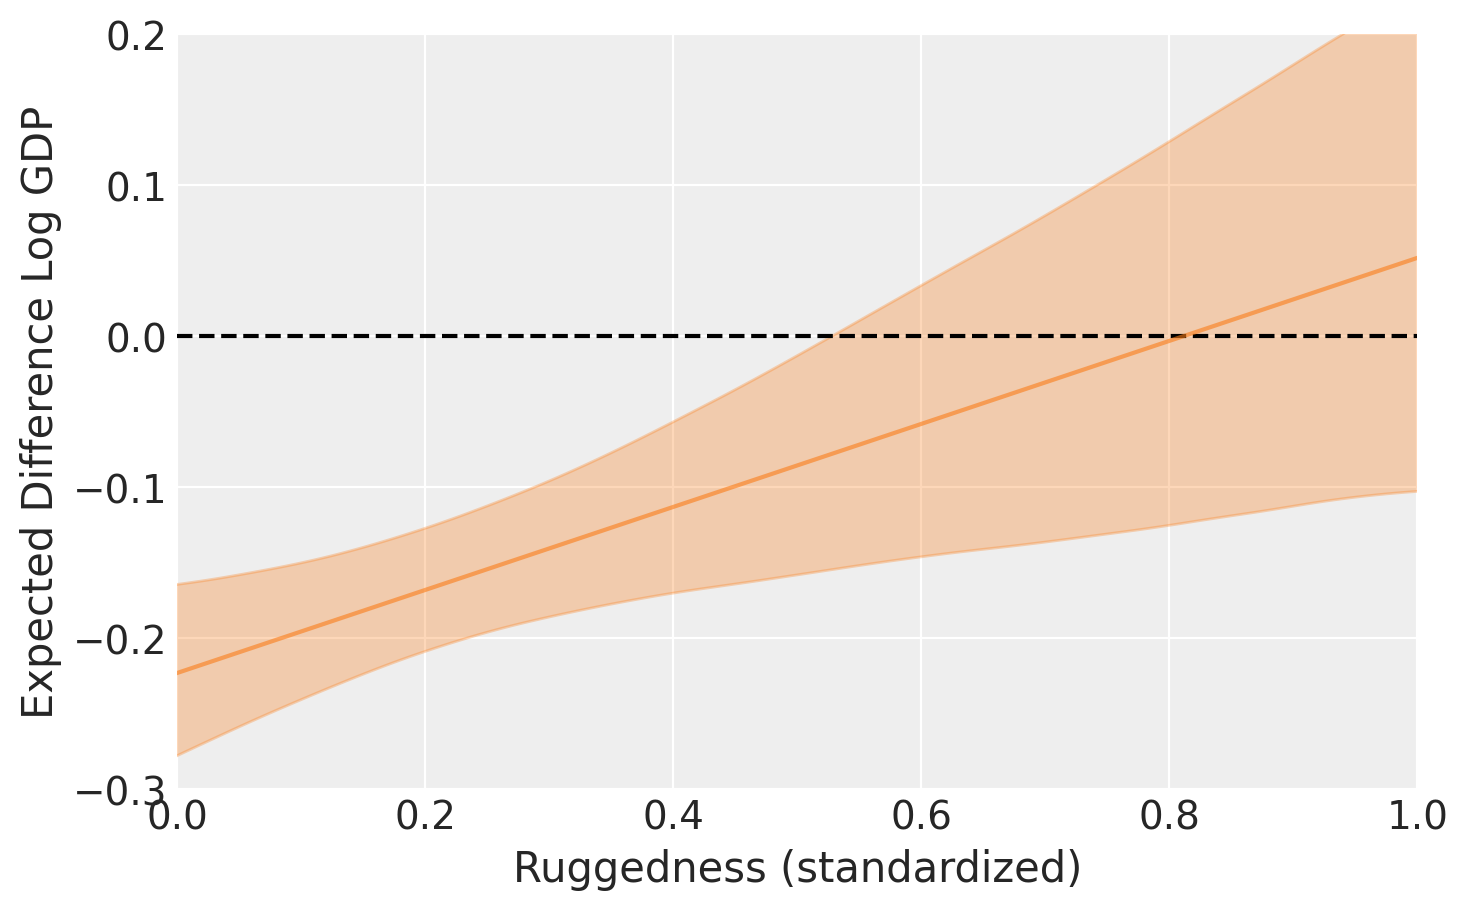

In [36]:
# plot results
fig = plt.figure(figsize=(8, 5))
plt.axhline(0, c="k", ls="--")
# mean
plt.plot(rugged_seq, delta.mean(1), color='C1', alpha=0.6)
# CI for mean
az.plot_hpd(rugged_seq, delta.T, color='C1', 
            fill_kwargs={'alpha': 0.3}, credible_interval=0.97)
plt.ylabel('Expected Difference Log GDP', fontsize=15)
plt.xlabel('Ruggedness (standardized)', fontsize=15)
plt.xlim([0, 1])
plt.ylim([-0.3, 0.2])
plt.show()

## 8.3. Continuous interactions

### 8.3.1. A winter flower

### Code 8.19 and Code 8.20

In [37]:
# load cars data
df = pd.read_csv("Data/tulips.csv", sep=";", header=0)

df['blooms_std'] = df['blooms'] / df['blooms'].max()
df['water_cent'] = df['water'] - df['water'].mean()
df['shade_cent'] = df['shade'] - df['shade'].mean()

df.head()

,bed,water,shade,blooms,blooms_std,water_cent,shade_cent
0,a,1,1,0.00,0.000000,-1.0,-1.0
1,a,1,2,0.00,0.000000,-1.0,0.0
2,a,1,3,111.04,0.307029,-1.0,1.0
3,a,2,1,183.47,0.507300,0.0,-1.0
4,a,2,2,59.16,0.163579,0.0,0.0


### 8.3.2. The models

### Code 8.21 and Code 8.22

In [38]:
a = stats.norm.rvs(loc=0.5, scale=1, size=10000)
(sum(a<0)+sum(a>1))/len(a)

0.617

In [39]:
a = stats.norm.rvs(loc=0.5, scale=0.25, size=10000)
(sum(a<0)+sum(a>1))/len(a)

0.0454

### Code 8.23

In [40]:
# define model: blooms ~ water + shade (no interaction)
with pm.Model() as m8_4:
    a = pm.Normal('a', mu=0.5, sigma=0.25)
    bW = pm.Normal('bW', mu=0, sigma=0.25)
    bS = pm.Normal('bS', mu=0, sigma=0.25)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a+bW*df['water_cent']+bS*df['shade_cent'])
    blooms_std = pm.Normal('blooms_std', mu=mu, sigma=sigma, observed=df['blooms_std'])
    m8_4_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bS, bW, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3680.36draws/s]


In [41]:
# show model summary
varnames = ['~mu']
az.summary(m8_4_trace, varnames, kind="stats",  round_to=2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
a,0.36,0.03,0.30,0.41
bW,0.20,0.04,0.14,0.27
bS,-0.11,0.04,-0.17,-0.04
sigma,0.18,0.03,0.13,0.22


### Code 8.24

In [42]:
# define model: blooms ~ water + shade (with interaction)
with pm.Model() as m8_5:
    a = pm.Normal('a', mu=0.5, sigma=0.25)
    bW = pm.Normal('bW', mu=0, sigma=0.25)
    bS = pm.Normal('bS', mu=0, sigma=0.25)
    bWS = pm.Normal('bWS', mu=0, sigma=0.25)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a+bW*df['water_cent']
                          +bS*df['shade_cent']
                          +bWS*df['water_cent']*df['shade_cent'])
    blooms_std = pm.Normal('blooms_std', mu=mu, sigma=sigma, observed=df['blooms_std'])
    m8_5_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bWS, bS, bW, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3468.45draws/s]


In [43]:
# show model summary
varnames = ['~mu']
az.summary(m8_5_trace, varnames, kind="stats",  round_to=2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
a,0.36,0.03,0.32,0.40
bW,0.21,0.03,0.15,0.26
bS,-0.11,0.03,-0.17,-0.06
bWS,-0.14,0.04,-0.20,-0.07
sigma,0.14,0.02,0.10,0.17


### 8.3.3. Plotting posterior predictions

### Code 8.25

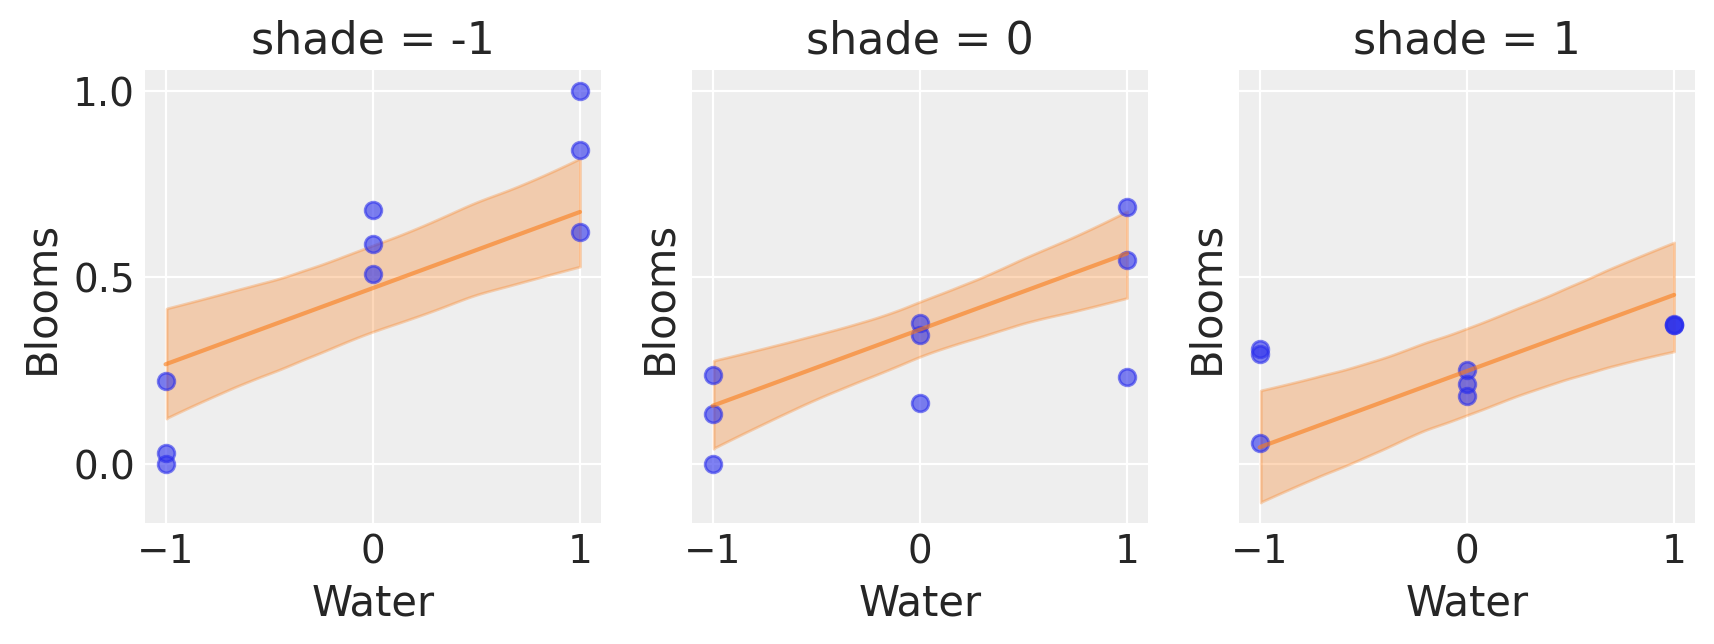

In [44]:
# no interaction
f, axs = plt.subplots(1, 3, sharey=True, figsize=(10,3))
# loop over values of shade and plot predictions.
shade_seq = np.linspace(-1, 1, 30)
mu_w = np.zeros((len(shade_seq), len(m8_4_trace) * m8_4_trace.nchains))
for ax, s in zip(axs.flat, range(-1, 2, 1)):
    dt = df[df['shade_cent'] == s]
    ax.plot(dt['water_cent'], dt['blooms_std'], 'C0o', alpha=0.6)
    for n, iSeq in enumerate(shade_seq):
        mu_w[n] = m8_4_trace['a'] + m8_4_trace['bW']*iSeq + m8_4_trace['bS']*s
    ax.plot(shade_seq, mu_w.mean(1), color='C1', alpha=0.6)
    az.plot_hpd(shade_seq, mu_w.T, color='C1', 
            fill_kwargs={'alpha': 0.3}, credible_interval=0.97, ax=ax)
    ax.set_ylabel('Blooms', fontsize=15)
    ax.set_xlabel('Water', fontsize=15)
    ax.set_title('shade = {:d}'.format(s))
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([0,0.5,1])

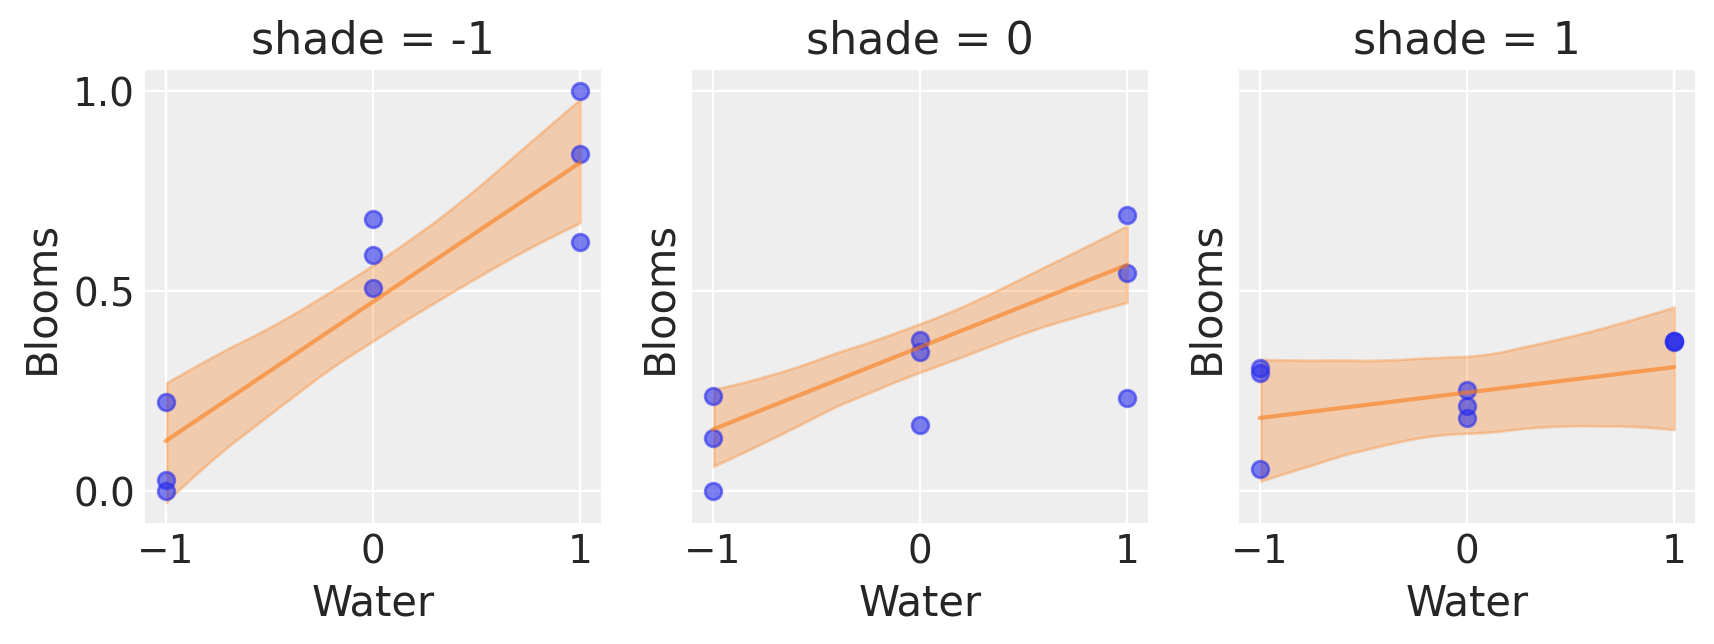

In [45]:
# interaction
f, axs = plt.subplots(1, 3, sharey=True, figsize=(10,3))
# loop over values of shade and plot predictions.
shade_seq = np.linspace(-1, 1, 30)
mu_w = np.zeros((len(shade_seq), len(m8_5_trace) * m8_5_trace.nchains))
for ax, s in zip(axs.flat, range(-1, 2, 1)):
    dt = df[df['shade_cent'] == s]
    ax.plot(dt['water_cent'], dt['blooms_std'], 'C0o', alpha=0.6)
    for n, iSeq in enumerate(shade_seq):
        mu_w[n] = m8_5_trace['a'] + m8_5_trace['bW']*iSeq + m8_5_trace['bS']*s +  m8_5_trace['bWS']*s*iSeq
    ax.plot(shade_seq, mu_w.mean(1), color='C1', alpha=0.6)
    az.plot_hpd(shade_seq, mu_w.T, color='C1', 
            fill_kwargs={'alpha': 0.3}, credible_interval=0.97, ax=ax)
    ax.set_ylabel('Blooms', fontsize=15)
    ax.set_xlabel('Water', fontsize=15)
    ax.set_title('shade = {:d}'.format(s))
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([0,0.5,1])

### 8.3.4. Plotting prior predictions

### Code 8.26

In [46]:
with m8_4:
    m8_4_prior_predictive = pm.sample_prior_predictive() 

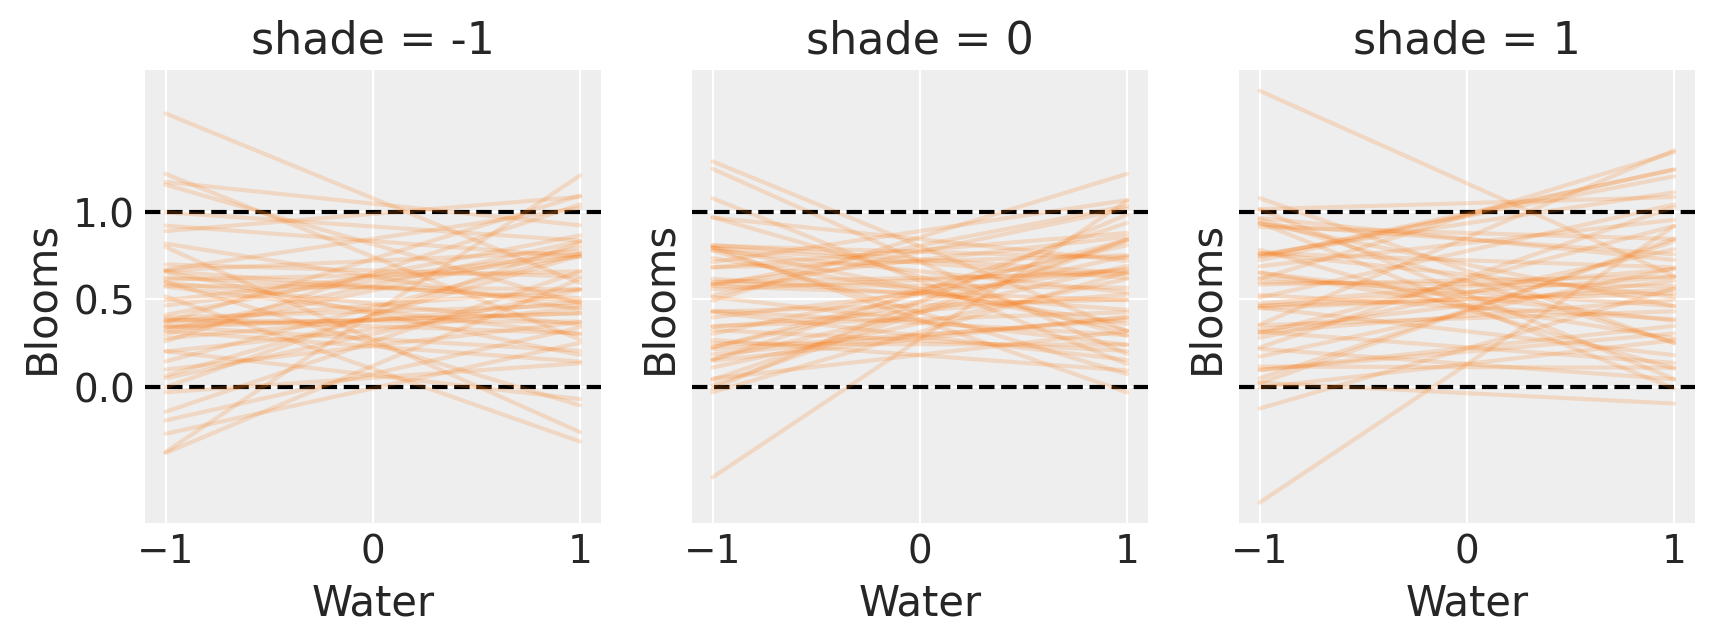

In [47]:
# no interaction
f, axs = plt.subplots(1, 3, sharey=True, figsize=(10,3))
# loop over values of shade and plot predictions.
shade_seq = np.linspace(-1, 1, 30)
mu_w = np.zeros((len(shade_seq), len(m8_4_trace) * m8_4_trace.nchains))
for ax, s in zip(axs.flat, range(-1, 2, 1)):
    ax.axhline(0, c="k", ls="--")
    ax.axhline(1, c="k", ls="--")
    for a, bW, bS in zip(m8_4_prior_predictive['a'][:50], m8_4_prior_predictive['bW'][:50], m8_4_prior_predictive['bS'][:50]):
        y = a + bW*shade_seq + bS*s
        ax.plot(shade_seq, y, c='C1', alpha=0.2)
    ax.set_ylabel('Blooms', fontsize=15)
    ax.set_xlabel('Water', fontsize=15)
    ax.set_title('shade = {:d}'.format(s))
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([0,0.5,1])

In [48]:
with m8_5:
    m8_5_prior_predictive = pm.sample_prior_predictive() 

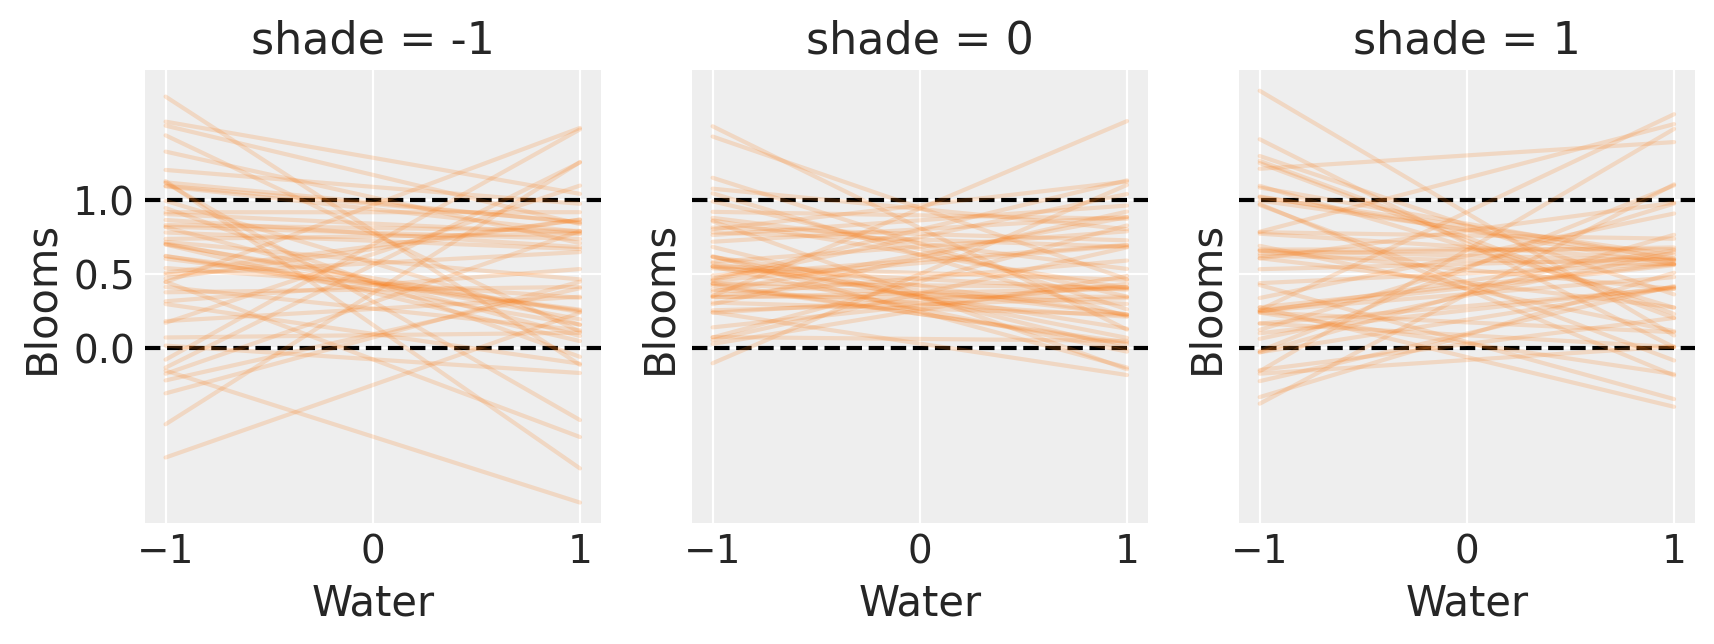

In [49]:
# interaction
f, axs = plt.subplots(1, 3, sharey=True, figsize=(10,3))
# loop over values of shade and plot predictions.
shade_seq = np.linspace(-1, 1, 30)
mu_w = np.zeros((len(shade_seq), len(m8_5_trace) * m8_5_trace.nchains))
for ax, s in zip(axs.flat, range(-1, 2, 1)):
    ax.axhline(0, c="k", ls="--")
    ax.axhline(1, c="k", ls="--")
    for a, bW, bS, bWS in zip(m8_5_prior_predictive['a'][:50], m8_5_prior_predictive['bW'][:50], m8_5_prior_predictive['bS'][:50], m8_5_prior_predictive['bWS'][:50]):
        y = a + bW*shade_seq + bS*s + bWS*shade_seq*s
        ax.plot(shade_seq, y, c='C1', alpha=0.2)
    ax.set_ylabel('Blooms', fontsize=15)
    ax.set_xlabel('Water', fontsize=15)
    ax.set_title('shade = {:d}'.format(s))
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([0,0.5,1])

### Referece

[pymc-devs: Rethinking_1 Chp07](https://github.com/pymc-devs/resources/blob/master/Rethinking/Chp_07.ipynbb)